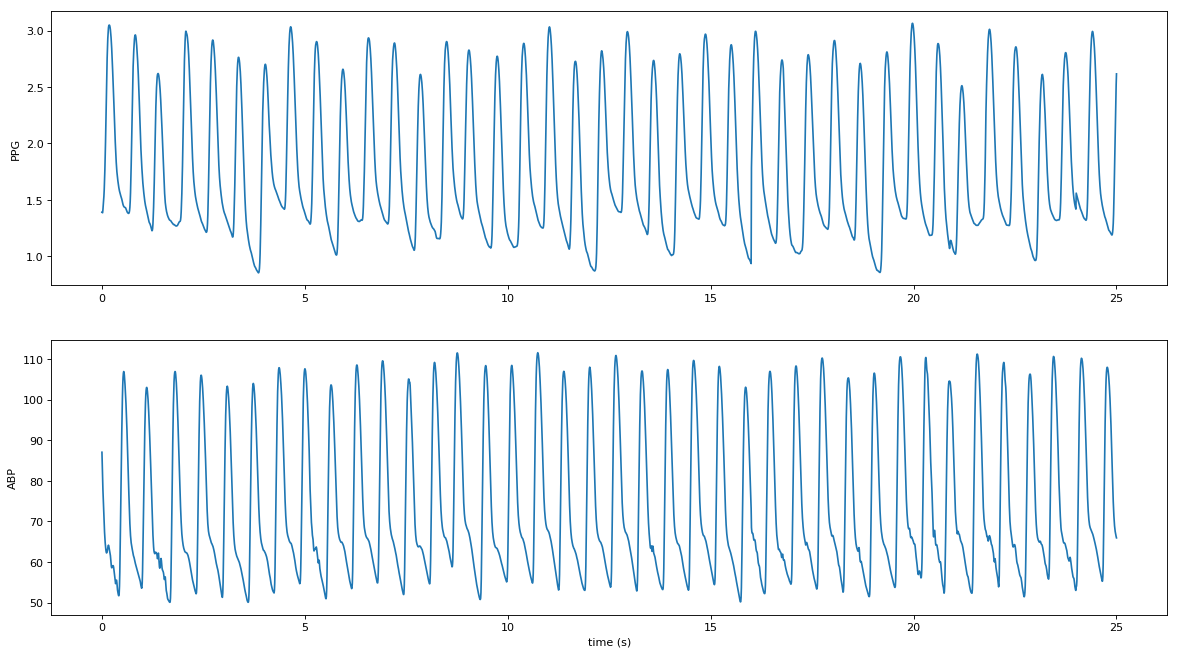

In [16]:
fig=plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
plot_recording(rid = 115, length2plot = 25)

In [187]:
import numpy as np
import scipy.io
from scipy.signal import decimate, correlate
from detect_peaks import detect_peaks
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import time
import os
import warnings
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder


Srate = 125
NewSrate = 25

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy Numpy warnings

# Load Part with ID
def load_data_part(pid = 1):
    data_part = scipy.io.loadmat('../database/KData/BloodPressureDataset/part_' + str(pid) + '.mat')
    return data_part
    
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / np.mean(window)) - 1) for p in window]
        normalised_data.append(normalised_window)
    normalised_data = np.array(normalised_data)
    return normalised_data

# align ABP according to PPG
def PPG_ABP_align(PPG, ABP, range4corr = 0.7):
    """
    @Parameters:
    PPG:
    ABP:
    range4corr: the temporal range (in seconds) for performing cross-correlation
    @return: 
    ABP: updated ABP 
    """
    from scipy.signal import correlate

    corr_with_lag = correlate(PPG, ABP, mode = "same")
    lag = np.argmax(corr_with_lag[len(corr_with_lag)-int(np.floor(range4corr*NewSrate)) : len(corr_with_lag)+int(np.floor(range4corr*NewSrate))])
    ABP = np.roll(ABP, shift=int(np.ceil(lag)))
    return ABP

## extract SBP, DBP from true and estimated ABP
def extract_BP_from_ABP(signal, show = False):
    """
    @Parameters:
    signal: ABP signal, 1-D
    @Return:
    SBP: a list of SBP values (associated with peaks on ABP signal)
    DBP: a list of DBP values (associated with valleys on ABP signal)
    SBP_ind: temporal location of peaks
    DBP_ind: temporal location of valleys
    """
    from detect_peaks import detect_peaks

    # find the temporal location of peaks and valleys based on True data
    # Minimum height for SBP (peak of the signal)
    MinHight4SBP = 80
    MaxHight4DBP = 110
    MinDistance  = 0.4 * NewSrate
    SBP_ind = detect_peaks(signal, mph = MinHight4SBP, mpd = MinDistance, valley = False, show=show)
    DBP_ind = detect_peaks(signal, mph = -MaxHight4DBP, mpd = MinDistance, valley = True, show=show)
    SBP = signal[SBP_ind]
    DBP = signal[DBP_ind]
    return [SBP, DBP, SBP_ind, DBP_ind]
    
def build_model_lstm(layers):
    lstm_model = Sequential()

    lstm_model.add(LSTM(
        input_shape=(layers[1], layers[0]),
        output_dim=layers[1],
        return_sequences=True))
    lstm_model.add(Dropout(0.00000000001))

    lstm_model.add(LSTM(
        layers[2],
        return_sequences=False))
    lstm_model.add(Dropout(0.00000000001))
    
    lstm_model.add(Dense(
        output_dim=layers[3]))
    lstm_model.add(Activation("relu"))

    lstm_model.add(Dense(
    output_dim=layers[4]))
    lstm_model.add(Activation("tanh"))
    
    lstm_model.add(Dense(
        output_dim=layers[5]))
#     lstm_model.add(Activation("linear"))

    start = time.time()
    lstm_model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    
    return lstm_model

def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
#     predicted = np.reshape(predicted, (predicted.shape[0],,))
    
    return predicted

def cal_error_DBP(true, pred):
    DBP_pred = pred[:,1]
    DBP_label = true[:,1]
    DBP_R = np.corrcoef(DBP_pred, DBP_label)
    DBP_MAE = (np.absolute((DBP_pred - DBP_label))).mean()
    DBP_MAE_std = np.std((DBP_pred - DBP_label))
    DBP_RMSE = np.sqrt(((DBP_pred - DBP_label) ** 2).mean()) 
    # t_DBP, p_DBP = ttest_ind(DBP_pred, DBP_label)
    print("R of DBP    = {}".format(DBP_R[0][1]))
    # print("p of DBP    = {}".format(p_DBP))
    print("MAE of DBP  = {} +/- {}".format(DBP_MAE, DBP_MAE_std))
    print("RMSE of DBP = {}\n".format(DBP_RMSE))
    plt.plot(DBP_label, DBP_pred, "o")
    axes = plt.gca()
    axes.set_xlim([60,120])
    axes.set_ylim([60,120])
    plt.show()

def cal_error_SBP(true, pred):
    SBP_pred = pred[:,0]
    SBP_label = true[:,0]
    SBP_R = np.corrcoef(SBP_pred, SBP_label)
    SBP_MAE = (np.absolute((SBP_pred - SBP_label))).mean()
    SBP_MAE_std = np.std((SBP_pred - SBP_label))
    SBP_RMSE = np.sqrt(((SBP_pred - SBP_label) ** 2).mean())
    print("R of SBP    = {}".format(SBP_R[0][1]))
    print("MAE of DBP  = {} +/- {}".format(SBP_MAE, SBP_MAE_std))
    print("RMSE of SBP = {}".format(SBP_RMSE))
    plt.plot(SBP_label, SBP_pred, "o")
    axes = plt.gca()
    axes.set_xlim([90,170])
    axes.set_ylim([90,170])
    plt.show()

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

### Preprocessing / Separation Data

In [250]:
def separate_train_test(pid, rids, win_len, dSamp = True, label_type = 2, normalise_flag = False, align_flag = False):
    """
    @Parameters:
    pid: Part ID (1~12)
    rid: Recording ID (1~1000)
    win_len: window length in the unit of time point
    label_type: int '1' represents SBP and DBP; int '0' represents ABP time points
    @return:
    if label_type == 0:    x_train, y_train, x_test, y_test
    if label_type == 1:    x_train, y_trLab, x_test, y_teLab. Note: y_trLab and y_teLab are arrays of[SBP, DBP]
    if label_type == 2:    x_train, y_trLab, x_test, y_teLab. Note: y_trLab and y_teLab are one-hot of[SBP, DBP]
    """
    print ('> Loading data part_' + str(pid) + '...\n')
    data_part = load_data_part(pid)
    PPG_seg, ABP_seg = [], []
    sequence_length = win_len     
    
    for rid in rids:
        data_raw = data_part['p'][0][rid]
        PPG = data_raw[0]
        ABP = data_raw[1]

        # down sampling after anti-alias filtering
        if dSamp:
            downSampleRate = int(Srate / NewSrate)
            PPG = decimate(PPG, downSampleRate, n=None, ftype='iir', axis=-1, zero_phase=True)
            ABP = decimate(ABP, downSampleRate, n=None, ftype='iir', axis=-1, zero_phase=True)

        if normalise_flag:
            PPG.shape
            scaler = MinMaxScaler(feature_range=(-1, 1))
            PPG = scaler.fit_transform(PPG.reshape(len(PPG), 1))
            
        if align_flag:
            ABP = PPG_ABP_align(PPG, ABP, range4corr = 0.7)

        for index in range(len(PPG) - sequence_length):
            PPG_seg.append(PPG[index: index + sequence_length])
            ABP_seg.append(ABP[index: index + sequence_length])
            
#     if normalise_flag:
#         PPG_seg = normalise_windows(PPG_seg)

    PPG_seg = np.array(PPG_seg)
    ABP_seg = np.array(ABP_seg)
    
    row = round(0.8 * PPG_seg.shape[0])
    x_train = PPG_seg[:int(row), :]
    x_test  = PPG_seg[(int(row) + win_len - 1) :, :]
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test  = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    if label_type == 0:
        y_train = ABP_seg[:int(row), -1]
        y_test  = ABP_seg[(int(row) + win_len - 1) :, -1]

        return [x_train, y_train, x_test, y_test]
    
    elif label_type == 1:
        y_train = ABP_seg[:int(row), :]
        y_test  = ABP_seg[(int(row) + win_len - 1) :, :]
        
        # initial 2d arrays for SBP/DBP
        y_trLab = np.zeros(shape=(y_train.shape[0],2))
        y_teLab = np.zeros(shape=(y_test.shape[0],2))

        for i in range(y_trLab.shape[0]):
            SBP, DBP, _, _ = extract_BP_from_ABP(y_train[i, ])
            y_trLab[i,] = np.array([np.mean([SBP[-3:]]), np.mean([DBP[-3:]])])

        for i in range(y_teLab.shape[0]):
            SBP, DBP, _, _ = extract_BP_from_ABP(y_test[i, ])
            y_teLab[i,] = np.array([np.mean([SBP[-3:]]), np.mean([DBP[-3:]])])
    
        return [x_train, y_trLab, x_test, y_teLab]
    
    elif label_type == 2: # one-hot SBP as label
        y_train = ABP_seg[:int(row), :]
        y_test  = ABP_seg[(int(row) + win_len - 1) :, :]
        
        # initial 2d arrays for SBP/DBP
        y_tr = np.zeros(shape=(y_train.shape[0],2))
        y_te = np.zeros(shape=(y_test.shape[0],2))

        for i in range(y_train.shape[0]):
            SBP, DBP, _, _ = extract_BP_from_ABP(y_train[i, ])
            y_tr[i,] = np.array([np.mean([SBP[-3:]]), np.mean([DBP[-3:]])])

        for i in range(y_test.shape[0]):
            SBP, DBP, _, _ = extract_BP_from_ABP(y_test[i, ])
            y_te[i,] = np.array([np.mean([SBP[-3:]]), np.mean([DBP[-3:]])])
            
        #find the range of SBP and DBP respectively
        Y_pool = np.concatenate((y_tr, y_te), axis = 0)
        
        Ymax_SBP, Ymin_SBP = int(np.rint(np.amax(Y_pool[:,0]))), int(np.rint(np.amin(Y_pool[:,0])))
        Y_all_labels_SBP = np.array((range(Ymin_SBP, Ymax_SBP + 1)))
        
        Ymax_DBP, Ymin_DBP = int(np.rint(np.amax(Y_pool[:,1]))), int(np.rint(np.amin(Y_pool[:,1])))
        Y_all_labels_DBP = np.array((range(Ymin_DBP, Ymax_DBP + 1)))
        
        label_encoder_SBP, onehot_encoder_SBP = train_label_onehot_encoder(Y_all_labels_SBP)
        label_encoder_DBP, onehot_encoder_DBP = train_label_onehot_encoder(Y_all_labels_DBP)

        Y_tr_SBP = onehot_encode_label(np.rint(y_tr[:,0]).astype(int), label_encoder_SBP, onehot_encoder_SBP)
        Y_te_SBP = onehot_encode_label(np.rint(y_te[:,0]).astype(int), label_encoder_SBP, onehot_encoder_SBP)

        Y_tr_DBP = onehot_encode_label(np.rint(y_tr[:,1]).astype(int), label_encoder_DBP, onehot_encoder_DBP)
        Y_te_DBP = onehot_encode_label(np.rint(y_te[:,1]).astype(int), label_encoder_DBP, onehot_encoder_DBP)
    
        return x_train, Y_tr_SBP, Y_tr_DBP, x_test, Y_te_SBP, Y_te_DBP, label_encoder_SBP, label_encoder_DBP, onehot_encoder_SBP, onehot_encoder_DBP
    
    elif label_type == 3: # only SBP as label
        y_train = ABP_seg[:int(row), :]
        y_test  = ABP_seg[(int(row) + win_len - 1) :, :]
        
        # initial 1d arrays for SBP/DBP
        y_trLab = np.zeros(shape=(y_train.shape[0],1))
        y_teLab = np.zeros(shape=(y_test.shape[0],1))

        for i in range(y_trLab.shape[0]):
            SBP, DBP, _, _ = extract_BP_from_ABP(y_train[i, ])
            y_trLab[i,] = np.array([np.mean([SBP[-3:]]), np.mean([DBP[-3:]])])

        for i in range(y_teLab.shape[0]):
            SBP, DBP, _, _ = extract_BP_from_ABP(y_test[i, ])
            y_teLab[i,] = np.array([np.mean([SBP[-3:]]), np.mean([DBP[-3:]])])
    
        return [x_train, y_trLab, x_test, y_teLab]

### One-hot coding

In [298]:
def train_label_onehot_encoder(all_labels):
    """
    Given all possible labels, train an onehot encoder algorithm
    @Parameters:
    all_labels: all possible numerical labels for SBP or DBP
    @Returns:
    label_encoder: trained scikit-learn object LsbelEncoder
    onehot_encoder: trained scikit-learn object OnehotEncoder
    """
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(all_labels)

    onehot_encoder = OneHotEncoder(sparse = False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    return label_encoder, onehot_encoder

def onehot_encode_label(label_to_encode,label_encoder, onehot_encoder):
    """
    Given an array of labels (SBP or DBP), return their one-hot code
    @Parameters:
    label_to_encode: an array of labels (SBP or DBP), with shape (n_sample,1)
    label_encoder: trained scikit-learn object LsbelEncoder
    onehot_encoder: trained scikit-learn object OnehotEncoder
    @Returns:
    onehot_encoded: encoded labels, array of shape(n_sample,n_codelength) 
    """
    Y_label = label_encoder.transform(label_to_encode)
    onehot_encoded = onehot_encoder.transform(Y_label.reshape(len(Y_label),1))
    return onehot_encoded

def label_decode_onehot(label_to_decode, label_encoder):
    """
    Given an array of one-hot codes, return their associated labels
    @Parameters:
    label_to_decode: binary one-hot code, with shape (n_sample, n_codelength)
    label_encoder: trained scikit-learn object LsbelEncoder
    onehot_encoder: trained scikit-learn object OnehotEncoder
    @Returns:
    decimal labels: an array of labels (SBP or DBP), with shape (n_sample, 1)
    """
    decimal_labels = label_encoder.inverse_transform([np.argmax(label_to_decode, axis = 1)])
    decimal_labels = decimal_labels.T
    return decimal_labels

### Run: Build and Train Model

In [311]:
# load and prepare data
global_start_time = time.time()
epochs  = 100
win_len = 3 * NewSrate # 5 s in down sampled data
pid = 1
rids = [1]
# rid = [1,2,3,4,5,7,16,17, 19, 20]
dSamp = True
normalise_flag = True
align_flag = False
label_type = 2
epochs_to_wait_for_improve = 2

if label_type == 0:
    layers = [1, win_len, win_len * 2, win_len * 7, win_len * 3, 1]
elif label_type == 1:
    layers = [1, win_len, win_len * 2, win_len * 7, win_len * 3, 1] # if last layer is 1, then train for SBP only

x_train, Y_tr_SBP, Y_tr_DBP, x_test, Y_te_SBP, Y_te_DBP, label_encoder_SBP, label_encoder_DBP, onehot_encoder_SBP, onehot_encoder_DBP = separate_train_test(pid, rids, win_len, dSamp = dSamp, label_type = label_type, normalise_flag = normalise_flag, align_flag = align_flag)

print ('Data loaded and separated')

> Loading data part_1...

Data loaded and separated


### Build model for one hot based classification

In [ ]:
def build_model_lstm_oneHot(layers, oneHot_code_len):
    """
    Given the layer settings, build the LSTM model
    @Parameters:
    layers: an array of the number of units on each layer
    """
    lstm_model = Sequential()

    lstm_model.add(LSTM(
        input_shape=(layers[1], layers[0]),
        output_dim=layers[1],
        return_sequences=True))
    lstm_model.add(Dropout(0.00000000001))

    lstm_model.add(LSTM(
        layers[2],
        return_sequences=False))
    lstm_model.add(Dropout(0.00000000001))
    
    lstm_model.add(Dense(
        output_dim=layers[3]))
    lstm_model.add(Activation("relu"))

    lstm_model.add(Dense(
    output_dim=layers[4]))
    lstm_model.add(Activation("tanh"))
    
    lstm_model.add(Dense(
        output_dim=layers[5]))
#     lstm_model.add(Activation("linear"))

    start = time.time()
    lstm_model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    
    return lstm_model



In [312]:
pwd

'/home/lz206/Dropbox/projects/Blood_Pressure/WFDB/RNN'

In [65]:

print('> Data Loaded. Compiling...')

lstm_model = build_model_lstm(layers)


# for early stop
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
earlyStopping = EarlyStopping(monitor='val_loss', patience = epochs_to_wait_for_improve, verbose=0, mode='auto')
callbacks_list = [checkpoint, earlyStopping]

history = lstm_model_oneHot.fit(
            X_train,
            Y_train[:,0],
            batch_size = 64,
            nb_epoch = epochs,
            verbose = 1,
            callbacks = callbacks_list,
            validation_split = 0.1)

> Loading data part_1...

> Data Loaded. Compiling...
> Compilation Time :  0.011838912963867188
Train on 8730 samples, validate on 970 samples
Epoch 1/100
8730/8730 [==============================] - 20s 2ms/step - loss: 8547.2838 - val_loss: 5669.7816

Epoch 00001: val_loss improved from inf to 5669.78157, saving model to weights.best.hdf5
Epoch 2/100
8730/8730 [==============================] - 20s 2ms/step - loss: 3816.3118 - val_loss: 2057.2759

Epoch 00002: val_loss improved from 5669.78157 to 2057.27586, saving model to weights.best.hdf5
Epoch 3/100
8730/8730 [==============================] - 20s 2ms/step - loss: 1069.3095 - val_loss: 270.3278

Epoch 00003: val_loss improved from 2057.27586 to 270.32784, saving model to weights.best.hdf5
Epoch 4/100
8730/8730 [==============================] - 20s 2ms/step - loss: 68.7981 - val_loss: 5.7331

Epoch 00004: val_loss improved from 270.32784 to 5.73311, saving model to weights.best.hdf5
Epoch 5/100
8730/8730 [=======================

In [ ]:
## plot data
def plot_recording(rid = 6, length2plot = 10):
    '''
    parameters:
    rid: recording ID
    length2plot: length to plot in the unit of second
    '''
    data_raw = data_part['p'][0][rid]
    PPG = data_raw[0]
    ABP = data_raw[1]

    xtic = np.linspace(0, length2plot, length2plot * Srate)

    plt.subplot(211)
    plt.plot(xtic, PPG[:length2plot * Srate].T)
    plt.ylabel('PPG')

    plt.subplot(212)
    plt.plot(xtic, ABP[:length2plot * Srate].T)
    plt.ylabel('ABP')
    plt.xlabel('time (s)')

    plt.show()
    
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    ax.plot(predicted_data, label='Predicted Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
#     for i, data in enumerate(predicted_data):
#         padding = [None for p in range(i * prediction_len)]
#         plt.plot(padding + data, label='Prediction')
    plt.legend()
    plt.show()
    plt.ylabel('ABP')
    plt.xlabel('time point')



### Plot Histgram of the BP values

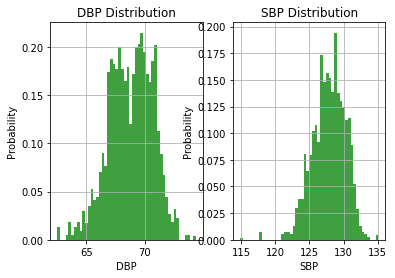

In [31]:
# concatenate train and test labels
YLabel = np.concatenate((Y_train, Y_test), axis = 0)

plt.subplot(121)
plt.hist(YLabel[:,1], 50, normed=1, histtype='stepfilled', facecolor='g', alpha=0.75)  # arguments are passed to np.histogram
plt.title("DBPc  Distribution")
plt.xlabel('DBP')
plt.ylabel('Probability')
plt.grid(True)

plt.subplot(122)
plt.hist(YLabel[:,0], 50, normed=1, histtype='stepfilled', facecolor='g', alpha=0.75)  # arguments are passed to np.histogram
plt.title("SBP Distribution")
plt.xlabel('SBP')
plt.ylabel('Probability')
# plt.savefig("BP_Distribution.svg", format="svg", bbox_inches='tight')
plt.grid(True)
plt.show()

In [84]:
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 75, 75)            23100     
_________________________________________________________________
dropout_13 (Dropout)         (None, 75, 75)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 150)               135600    
_________________________________________________________________
dropout_14 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 525)               79275     
_________________________________________________________________
activation_15 (Activation)   (None, 525)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 225)               118350    
__________

### Run: Test and Visualize the Model

In [66]:
lstm_model.load_weights(filepath)

R of SBP    = nan
MAE of DBP  = 1.9989713337784012 +/- 2.3408835398117223
RMSE of SBP = 2.452308929821662


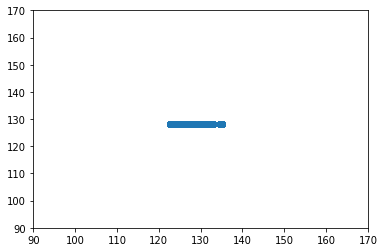

In [67]:
pred = predict_point_by_point(lstm_model, X_test)
cal_error_SBP(Y_test, pred)

In [94]:
Ymax, Ymin = int(np.rint(np.max(Y_train))), int(np.rint(np.min(Y_train)))
print (Ymax, Ymin)

134 63


In [69]:
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(121)
# plt.stem(Y_test[1501:1521,0], label='true')
# markerline, stemlines, baseline = plt.stem(pred[501:521,0], '-.', label='prediction')
# plt.setp(markerline, color='r', linewidth=2)

ax = fig.add_subplot(122)
plt.stem(Y_test[1501:1521,1], label='true')
markerline, stemlines, baseline = plt.stem(pred[501:521,1], '-.', label='prediction')
plt.setp(markerline, color='r', linewidth=2)

plt.legend()
plt.show()

IndexError: index 1 is out of bounds for axis 1 with size 1

In [74]:
SBP_R = np.corrcoef(SBP_pred, SBP_label)
SBP_MAE = (np.absolute((SBP_pred - SBP_label))).mean()
SBP_MAE_std = np.std((SBP_pred - SBP_label))
SBP_RMSE = np.sqrt(((SBP_pred - SBP_label) ** 2).mean())
print("R of SBP    = {}".format(SBP_R[0][1]))
print("MAE of DBP  = {} +/- {}".format(SBP_MAE, SBP_MAE_std))
print("RMSE of SBP = {}".format(SBP_RMSE))
plt.plot(SBP_label, SBP_pred, "o")
axes = plt.gca()
axes.set_xlim([90,170])
axes.set_ylim([90,170])
plt.show()

NameError: name 'SBP_pred' is not defined

### Load and Examine Dataset on one part

In [43]:
from detect_peaks import detect_peaks

Srate = 125
NewSrate = 25 # samples/second
downSampleRate = int(Srate / NewSrate)

pid, rid, win_len = 1, 1, 5 * NewSrate

data_part = load_data_part(pid)
data_raw = data_part['p'][0][rid]
PPG = data_raw[0]
ABP = data_raw[1]

# down sampling after anti-alias filtering
PPG = scipy.signal.decimate(PPG, downSampleRate, n=None, ftype='iir', axis=-1, zero_phase=True)
ABP = scipy.signal.decimate(ABP, downSampleRate, n=None, ftype='iir', axis=-1, zero_phase=True)

from scipy.signal import correlate

corr_with_lag = correlate(PPG, ABP, mode = "same")
lag = np.argmax(corr_with_lag[len(corr_with_lag)-int(np.floor(0.7*NewSrate)) : len(corr_with_lag)+int(np.floor(0.7*NewSrate))])
ABP_al = np.roll(ABP, shift=int(np.ceil(lag)))

# sequence_length = win_len + 1
sequence_length = win_len 
PPG_seg, ABP_seg = [], []
for index in range(len(PPG) - sequence_length):
    PPG_seg.append(PPG[index: index + sequence_length])
    ABP_seg.append(ABP[index: index + sequence_length])

PPG_seg = np.array(PPG_seg)
ABP_seg = np.array(ABP_seg)

row = round(0.08 * PPG_seg.shape[0])
x_train = PPG_seg[:int(row), :]
y_train = ABP_seg[:int(row), :]
x_test  = PPG_seg[int(row):, :]
y_test  = ABP_seg[int(row):, :]

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test  = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# initial 2d arrays for SBP/DBP
y_trLab = np.zeros(shape=(y_train.shape[0],2))
y_teLab = np.zeros(shape=(y_test.shape[0],2))

for i in range(y_trLab.shape[0]):
    SBP, DBP, _, _ = extract_BP_from_ABP(y_train[i, ])
    y_trLab[i,] = np.array([np.mean([SBP[-3:]]), np.mean([DBP[-3:]])])
    
for i in range(y_teLab.shape[0]):
    SBP, DBP, _, _ = extract_BP_from_ABP(y_test[i, ])
    y_teLab[i,] = np.array([np.mean([SBP[-3:]]), np.mean([DBP[-3:]])])


In [54]:
from sklearn.preprocessing import MinMaxScaler
PPG.shape
scaler = MinMaxScaler(feature_range=(-1, 1))
PPG_n = scaler.fit_transform(PPG.reshape(len(PPG), 1))

In [61]:
PPG_n.shape

(12200, 1)

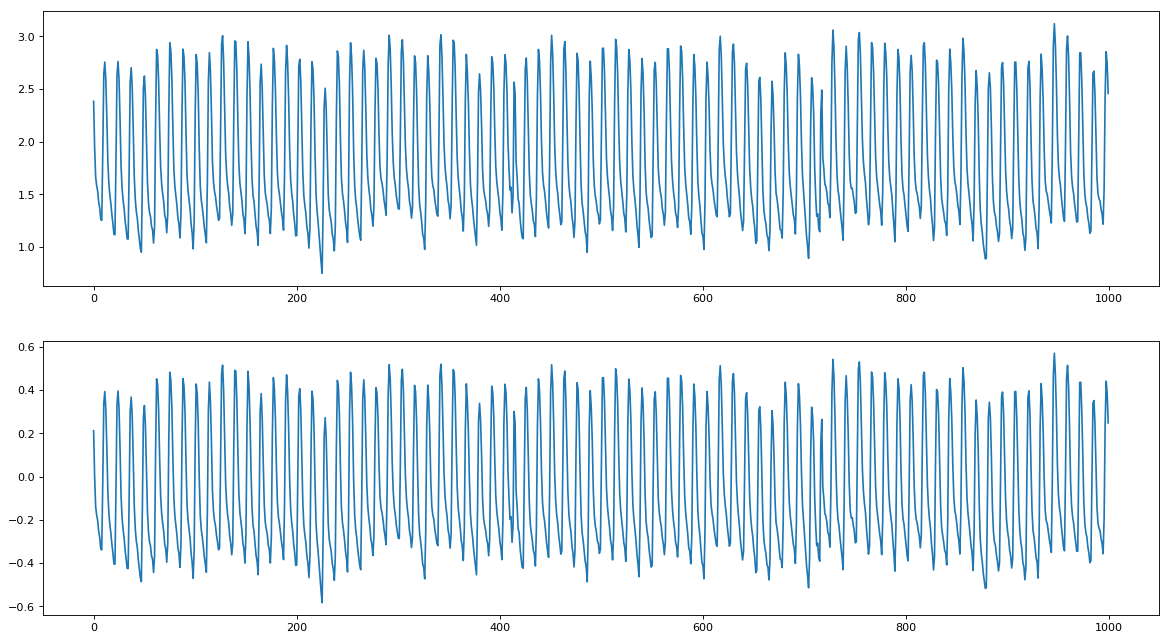

In [55]:
fig=plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(211)
plt.plot(PPG[:1000,])
plt.subplot(212)
plt.plot(PPG_n[:1000,])
plt.show()